注：预处理主要参照github项目NYC-Taxi-Demand-Prediction，
项目地址：https://github.com/jinalsalvi/NYC-Taxi-Demand-Prediction.git

In [1]:
import numpy as np
import pandas as pd

In [2]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import gpxpy.geo
from datetime import datetime
import time
import seaborn as sns
import os
import math
import matplotlib
matplotlib.use('nbagg')
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
warnings.simplefilter('ignore')

In [4]:
# 导入数据
df=pd.read_csv(r"C:\Users\lenovo\Desktop\yellow_tripdata_2014-04.csv",sep=',')
df.head()


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-04-08 08:59:39,2014-04-08 09:28:57,1,2.5,-73.958848,40.763585,1,N,-73.986284,40.752034,CRD,18.0,0.0,0.5,3.7,0.0,22.2
1,CMT,2014-04-08 14:59:22,2014-04-08 15:04:52,1,0.9,0.000000,0.000000,1,N,0.000000,0.000000,CRD,6.0,0.0,0.5,1.3,0.0,7.8
2,CMT,2014-04-08 08:45:28,2014-04-08 08:50:41,2,0.6,-73.992233,40.729136,1,N,-73.991387,40.735186,CRD,5.5,0.0,0.5,1.2,0.0,7.2
3,CMT,2014-04-08 08:00:20,2014-04-08 08:11:31,2,0.5,-73.973726,40.750095,1,N,-73.976889,40.755623,CRD,8.0,0.0,0.5,1.7,0.0,10.2
4,CMT,2014-04-08 08:38:36,2014-04-08 08:44:37,1,0.4,-73.973502,40.755479,1,Y,-73.979198,40.758619,CRD,5.5,0.0,0.5,1.2,0.0,7.2


In [5]:
df.info()
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14618759 entries, 0 to 14618758
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   vendor_id            object 
 1    pickup_datetime     object 
 2    dropoff_datetime    object 
 3    passenger_count     int64  
 4    trip_distance       float64
 5    pickup_longitude    float64
 6    pickup_latitude     float64
 7    rate_code           int64  
 8    store_and_fwd_flag  object 
 9    dropoff_longitude   float64
 10   dropoff_latitude    float64
 11   payment_type        object 
 12   fare_amount         float64
 13   surcharge           float64
 14   mta_tax             float64
 15   tip_amount          float64
 16   tolls_amount        float64
 17   total_amount        float64
dtypes: float64(11), int64(2), object(5)
memory usage: 2.0+ GB


Index(['vendor_id', ' pickup_datetime', ' dropoff_datetime',
       ' passenger_count', ' trip_distance', ' pickup_longitude',
       ' pickup_latitude', ' rate_code', ' store_and_fwd_flag',
       ' dropoff_longitude', ' dropoff_latitude', ' payment_type',
       ' fare_amount', ' surcharge', ' mta_tax', ' tip_amount',
       ' tolls_amount', ' total_amount'],
      dtype='object')

删除重复值、缺失值

In [6]:
nrows = df.shape[0]  # 初始行数

# 处理缺失值
df.dropna(inplace=True)
removed_rows = nrows - df.shape[0]
print("删除缺失值行数:", removed_rows)

# 输出处理后的数据行数
print("清洗后的数据行数:", df.shape[0])

删除缺失值行数: 7398774
清洗后的数据行数: 7219985


In [7]:
# 检查是否存在重复值
print("重复值数量：", df.duplicated().sum())

# 删除重复值
df = df.drop_duplicates()

# 重新检查是否存在重复值
print("删除后重复值的数量：", df.duplicated().sum())


重复值数量： 0
删除后重复值的数量： 0


In [7]:
df.shape[0]

7219985

删除不在纽约市范围内的数据

In [8]:
#detecting the pickups latitude and longitudes which are outside NYC.
outside_NYC = df[((df[' pickup_latitude'] <= 40.5774) | (df[' pickup_longitude'] <= -74.15) | (df[' pickup_latitude'] >= 40.9176) | (df[' pickup_longitude'] >= -73.7004))]
#latitude at equator is 0. Above equator latitude increases and becomes 90 at north pole. Below equator latitude decreases and
#is negative and becomes -90 at south pole.
#Longitude is 0 at United Kingdom(UK). To the right of UK, longitude increases positively and to the left of UK longitude decrease
#and is negative.

m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

outside_pickups = outside_NYC.head(25000)

for i,j in outside_pickups.iterrows():
    if j[" pickup_latitude"] != 0:
        folium.Marker([j[" pickup_latitude"], j[" pickup_longitude"]]).add_to(m)
m

发现大量数据不在纽约市范围内

In [9]:
#detecting the dropoff latitude and longitudes which are outside NYC.
outside_NYC = df[((df[' dropoff_latitude'] <= 40.5774) | (df[' dropoff_longitude'] <= -74.15) | (df[' dropoff_latitude'] >= 40.9176) | (df[' dropoff_longitude'] >= -73.7004))]
#latitude at equator is 0. Above equator latitude increases and becomes 90 at north pole. Below equator latitude decreases and
#is negative and becomes -90 at south pole.
#Longitude is 0 at United Kingdom(UK). To the right of UK, longitude increases positively and to the left of UK longitude decrease
#and is negative.

m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

outside_dropoff = outside_NYC.head(25000)

for i,j in outside_dropoff.iterrows():
    if j[" dropoff_latitude"] != 0:
        folium.Marker([j[" dropoff_latitude"], j[" dropoff_longitude"]]).add_to(m)
m
#documentation of folium: https://python-visualization.github.io/folium/docs-v0.6.0/quickstart.html#Getting-Started

In [10]:
dask_df = dd.from_pandas(df, npartitions=4 )

In [11]:
import dask.dataframe as dd

In [12]:
new_frame_cleaned = dask_df[(((dask_df[' pickup_latitude'] >= 40.5774) & (dask_df[' pickup_latitude'] <= 40.9176)) & ((dask_df[' pickup_longitude'] >= -74.15) & (df[' pickup_longitude'] <= -73.7004)))]

In [13]:
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned[' dropoff_latitude'] >= 40.5774) & (new_frame_cleaned[' dropoff_latitude'] <= 40.9176)) & ((new_frame_cleaned[' dropoff_longitude'] >= -74.15) & (new_frame_cleaned[' dropoff_longitude'] <= -73.7004)))]

In [14]:
#将时间字符串转换为Unix时间戳
def timeToUnix(t):
    #we have a time in the format "YYYY-MM-DD HH:MM:SS", which is a string
    change = datetime.strptime(t, "%Y-%m-%d %H:%M:%S") #this will convert the String time into datetime format
    t_tuple = change.timetuple() #this will convert the datetime formatted time into structured time
    return time.mktime(t_tuple) + 3600  #this will convert structured time into unix-time

#接受一个DataFrame对象df作为输入。该函数的主要目的是计算行程时长并添加到DataFrame中
def dfWithTripTimes(df):
    startTime = datetime.now()
    duration = df[[" pickup_datetime", " dropoff_datetime"]].compute()
    pickup_time = [timeToUnix(pkup) for pkup in duration[" pickup_datetime"].values]
    dropoff_time = [timeToUnix(drpof) for drpof in duration[" dropoff_datetime"].values]
#     trip_duration = []
#     for xy in zip(dropoff_time, pickup_time):
#         trip_duration.append(xy[0] - xy[1])
    trip_duration = (np.array(dropoff_time) - np.array(pickup_time))/float(60)  #trip duration in minutes
    
    NewFrame = df[[' passenger_count',' trip_distance',' pickup_longitude',' pickup_latitude',' dropoff_longitude',' dropoff_latitude',' total_amount']].compute()
    NewFrame[" trip_duration"] = trip_duration
    NewFrame[" pickup_time"] = pickup_time
    NewFrame["speed"] = (NewFrame[" trip_distance"]/NewFrame[" trip_duration"])*60  #speed in miles/hr
    
    print("Time taken for creation of dataframe is {}".format(datetime.now() - startTime))
    return NewFrame

In [16]:
new_frame = dfWithTripTimes(new_frame_cleaned)

Time taken for creation of dataframe is 0:06:31.874045


路程时长

<IPython.core.display.Javascript object>


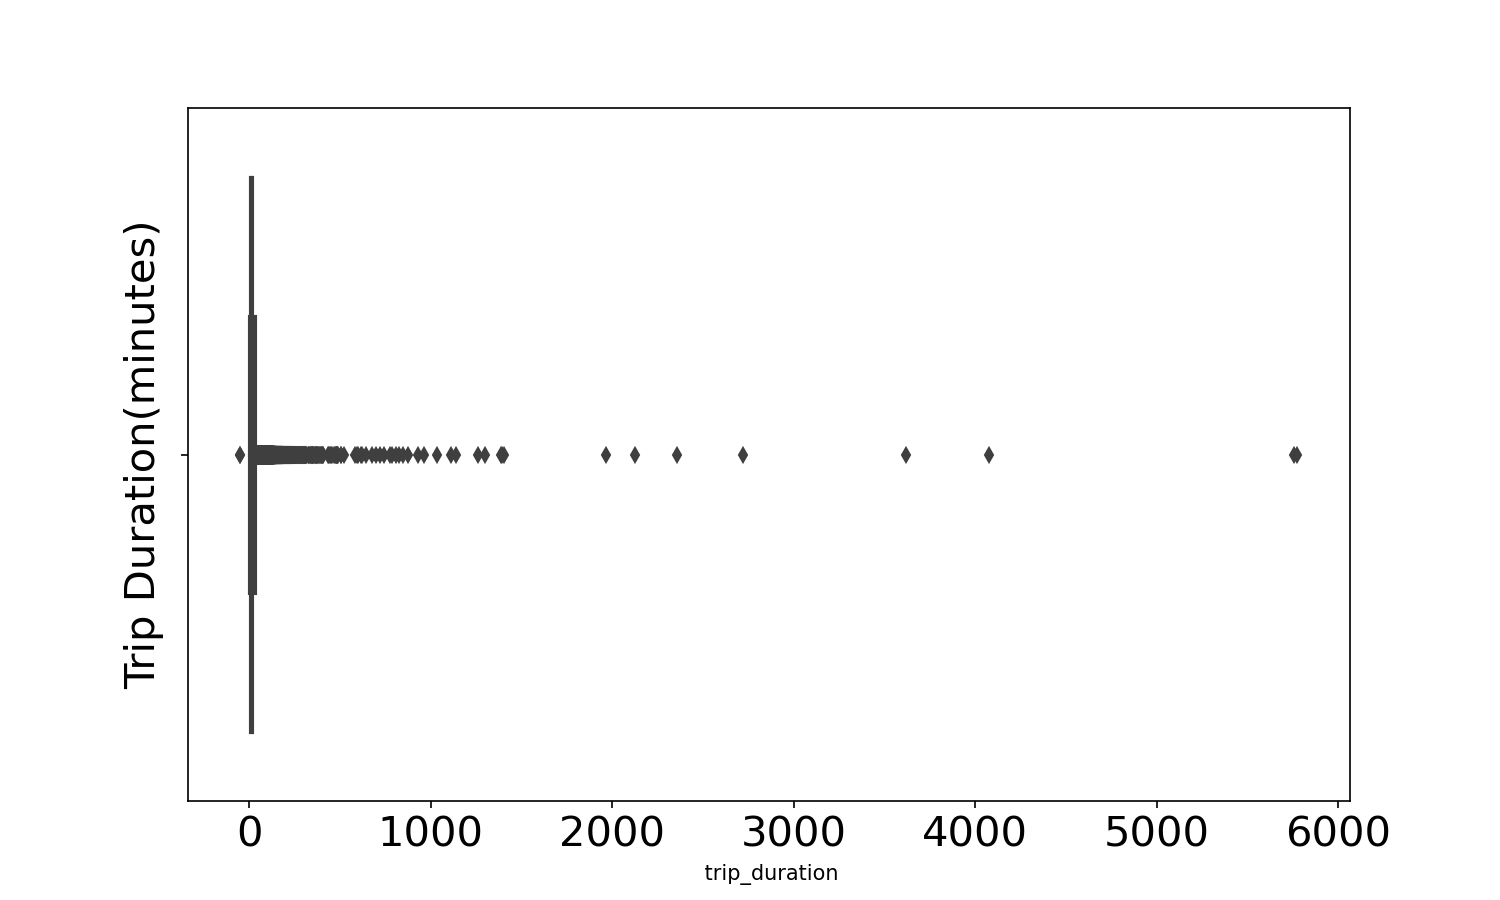

In [17]:
plt.figure(figsize = (10,6))
sns.boxplot(" trip_duration", data = new_frame, orient = "v")
plt.tick_params(labelsize = 20)
plt.ylabel("Trip Duration(minutes)", fontsize = 20)
plt.show()

In [18]:
quantile_tripDuration = new_frame[' trip_duration'].quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [19]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of Trip Duration is {}min".format((int(i*100)), quantile_tripDuration[i]))

0th percentile value of Trip Duration is -47.71666666666667min
10th percentile value of Trip Duration is 3.95min
20th percentile value of Trip Duration is 5.583333333333333min
30th percentile value of Trip Duration is 7.133333333333334min
40th percentile value of Trip Duration is 8.733333333333333min
50th percentile value of Trip Duration is 10.5min
60th percentile value of Trip Duration is 12.55min
70th percentile value of Trip Duration is 15.116666666666667min
80th percentile value of Trip Duration is 18.616666666666667min
90th percentile value of Trip Duration is 24.55min
100th percentile value of Trip Duration is 5774.25min


In [20]:
qValues = np.round(np.arange(0.90, 1.01, 0.01), 2)
for i in qValues:
    print("{} percentile value of Trip Duration is {}min".format((int(i*100)), quantile_tripDuration[i]))

90 percentile value of Trip Duration is 24.55min
91 percentile value of Trip Duration is 25.466666666666665min
92 percentile value of Trip Duration is 26.5min
93 percentile value of Trip Duration is 27.7min
94 percentile value of Trip Duration is 29.083333333333332min
95 percentile value of Trip Duration is 30.766666666666666min
96 percentile value of Trip Duration is 32.88333333333333min
97 percentile value of Trip Duration is 35.733333333333334min
98 percentile value of Trip Duration is 40.0min
99 percentile value of Trip Duration is 47.93333333333333min
100 percentile value of Trip Duration is 5774.25min


In [21]:
new_frame_cleaned = new_frame[(new_frame[' trip_duration']>1) & (new_frame[' trip_duration']<720)]

速度

In [22]:
def changingLabels(num):
    if num < 10**3:
        return num
    elif num>=10**3 and num < 10**6:
        return str(num/10**3)+"k"
    elif num>=10**6 and num < 10**9:
        return str(num/10**6) + "M"
    else:
        return str(num/10**9) + "B"

<IPython.core.display.Javascript object>


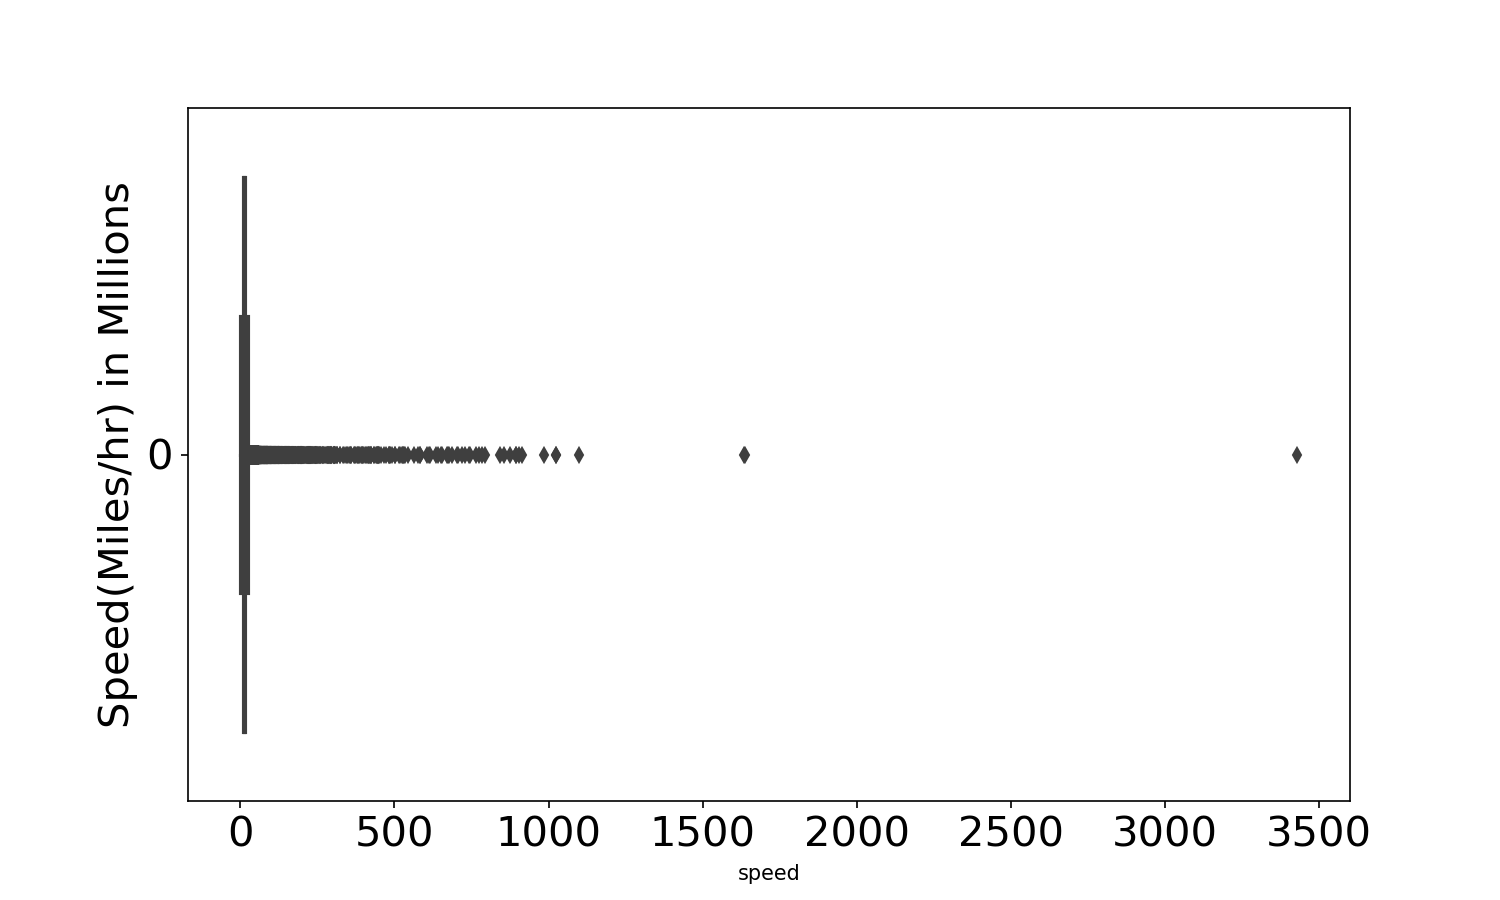

In [23]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("speed", data = new_frame_cleaned, orient = "v")

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize = 20)
plt.ylabel("Speed(Miles/hr) in Millions", fontsize = 20)
plt.show()

In [24]:
quantile_speed = new_frame_cleaned.speed.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [25]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 4)
for i in qValues:
    print("{}th percentile value of speed is {}miles/hr".format(int(i*100), quantile_speed[i]))

0th percentile value of speed is 0.0miles/hr
10th percentile value of speed is 5.929411764705882miles/hr
20th percentile value of speed is 7.433628318584069miles/hr
30th percentile value of speed is 8.653846153846153miles/hr
40th percentile value of speed is 9.80544747081712miles/hr
50th percentile value of speed is 10.992366412213743miles/hr
60th percentile value of speed is 12.311901504787961miles/hr
70th percentile value of speed is 13.917525773195877miles/hr
80th percentile value of speed is 16.173044925124792miles/hr
90th percentile value of speed is 20.36842105263158miles/hr
100th percentile value of speed is 3428.571428571429miles/hr


In [26]:
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print("{} percentile value of speed is {}miles/hr".format(int(i*100), quantile_speed[i]))

91 percentile value of speed is 21.050119331742245miles/hr
92 percentile value of speed is 21.81818181818182miles/hr
93 percentile value of speed is 22.702702702702705miles/hr
94 percentile value of speed is 23.73626373626373miles/hr
95 percentile value of speed is 24.953051100281233miles/hr
96 percentile value of speed is 26.432264736297828miles/hr
97 percentile value of speed is 28.30038350063039miles/hr
98 percentile value of speed is 30.83123425692695miles/hr
99 percentile value of speed is 34.80153649167733miles/hr
100 percentile value of speed is 3428.571428571429miles/hr


In [26]:
qValues = np.round(np.arange(0.991, 1.001, 0.001), 4)
quantile_speed = new_frame_cleaned.speed.quantile(qValues)
for i in qValues:
    print("{} percentile value of speed is {}miles/hr".format((i*100), quantile_speed[i]))

99.1 percentile value of speed is 35.36464119904293miles/hr
99.2 percentile value of speed is 35.976852213715055miles/hr
99.3 percentile value of speed is 36.66666666666667miles/hr
99.4 percentile value of speed is 37.443120260021665miles/hr
99.5 percentile value of speed is 38.326258279009096miles/hr
99.6 percentile value of speed is 39.36509318048357miles/hr
99.7 percentile value of speed is 40.664153464184324miles/hr
99.8 percentile value of speed is 42.40294618639915miles/hr
99.9 percentile value of speed is 45.17743139038387miles/hr
100.0 percentile value of speed is 3428.571428571429miles/hr


In [27]:
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.speed>0) & (new_frame_cleaned.speed<45.31)]

In [28]:
new_frame_cleaned.shape[0]

6959938

<IPython.core.display.Javascript object>


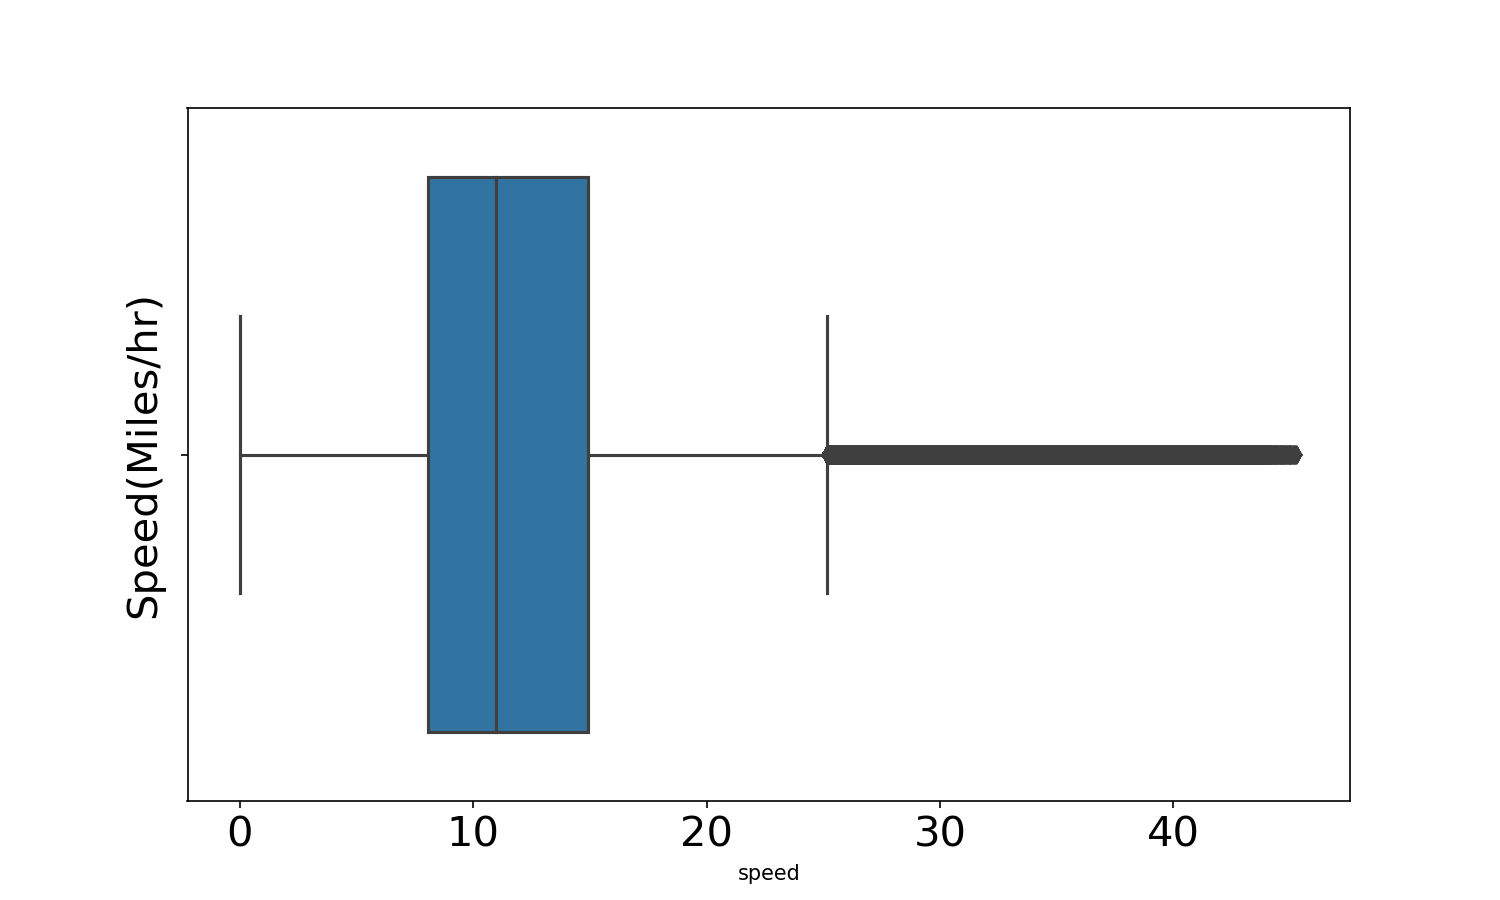

In [29]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("speed", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Speed(Miles/hr)", fontsize = 20)
plt.show()

In [30]:
Average_speed = sum(new_frame_cleaned.speed)/len(new_frame_cleaned.speed)
print("Average Speed of Taxis around NYC = "+str(Average_speed))

Average Speed of Taxis around NYC = 12.310903212494482


In [31]:
print("Speed of Taxis around NYC per 10 minutes = "+str(Average_speed/6)+" per 10 minutes.")

Speed of Taxis around NYC per 10 minutes = 2.0518172020824137 per 10 minutes.


路程距离

<IPython.core.display.Javascript object>


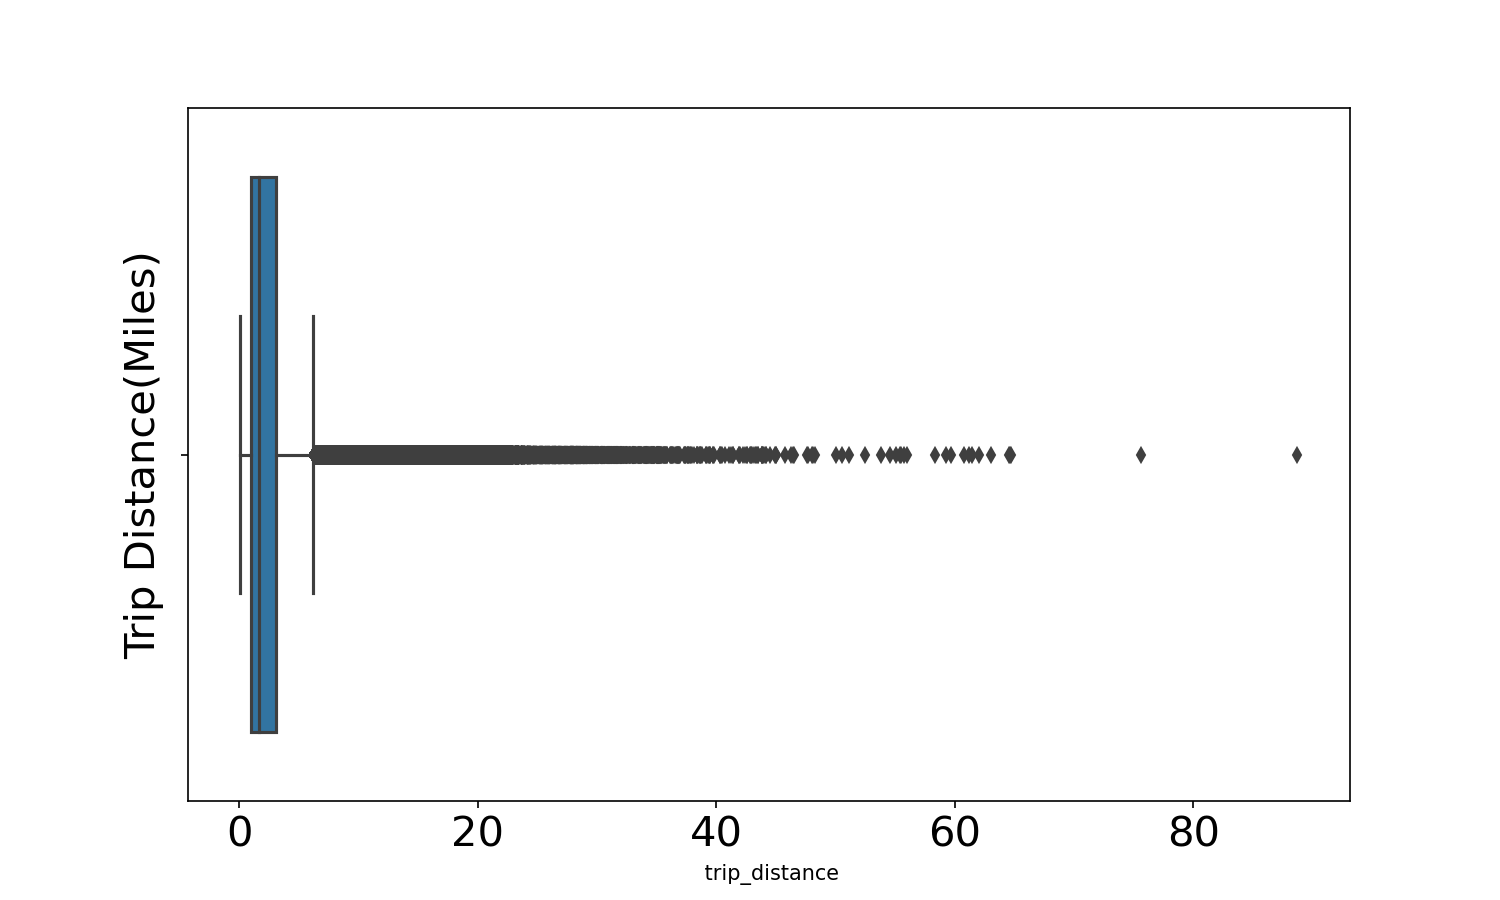

In [32]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(" trip_distance", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Distance(Miles)", fontsize = 20)
plt.show()

In [33]:
quantile_tripDistance = new_frame_cleaned[' trip_distance'].quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [34]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of trip distance is {}miles".format(int(i*100), quantile_tripDistance[i]))

0th percentile value of trip distance is 0.1miles
10th percentile value of trip distance is 0.6999999999999998miles
20th percentile value of trip distance is 0.9miles
30th percentile value of trip distance is 1.2miles
40th percentile value of trip distance is 1.4miles
50th percentile value of trip distance is 1.7miles
60th percentile value of trip distance is 2.1miles
70th percentile value of trip distance is 2.7miles
80th percentile value of trip distance is 3.7miles
90th percentile value of trip distance is 6.1miles
100th percentile value of trip distance is 88.7miles


In [35]:
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print("{} percentile value of trip distance is {}miles".format(int(i*100), quantile_tripDistance[i]))

91 percentile value of trip distance is 6.5miles
92 percentile value of trip distance is 7.1miles
93 percentile value of trip distance is 7.9miles
94 percentile value of trip distance is 8.699999999999998miles
95 percentile value of trip distance is 9.5miles
96 percentile value of trip distance is 10.4miles
97 percentile value of trip distance is 11.6miles
98 percentile value of trip distance is 14.9miles
99 percentile value of trip distance is 17.8miles
100 percentile value of trip distance is 88.7miles


In [36]:
quantile_tripDistance = new_frame_cleaned[' trip_distance'].quantile(np.round(np.arange(0.991, 1.001, 0.001), 4))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} percentile value of trip distance is {}miles".format((i*100), quantile_tripDistance[i]))

99.1 percentile value of trip distance is 18.0miles
99.2 percentile value of trip distance is 18.2miles
99.3 percentile value of trip distance is 18.4miles
99.4 percentile value of trip distance is 18.7miles
99.5 percentile value of trip distance is 19.1miles
99.6 percentile value of trip distance is 19.5miles
99.7 percentile value of trip distance is 20.1miles
99.8 percentile value of trip distance is 20.8miles
99.9 percentile value of trip distance is 21.8miles
100.0 percentile value of trip distance is 88.7miles


In [37]:
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned[' trip_distance']>0) & (new_frame_cleaned[' trip_distance']<23)]

总费用

<IPython.core.display.Javascript object>


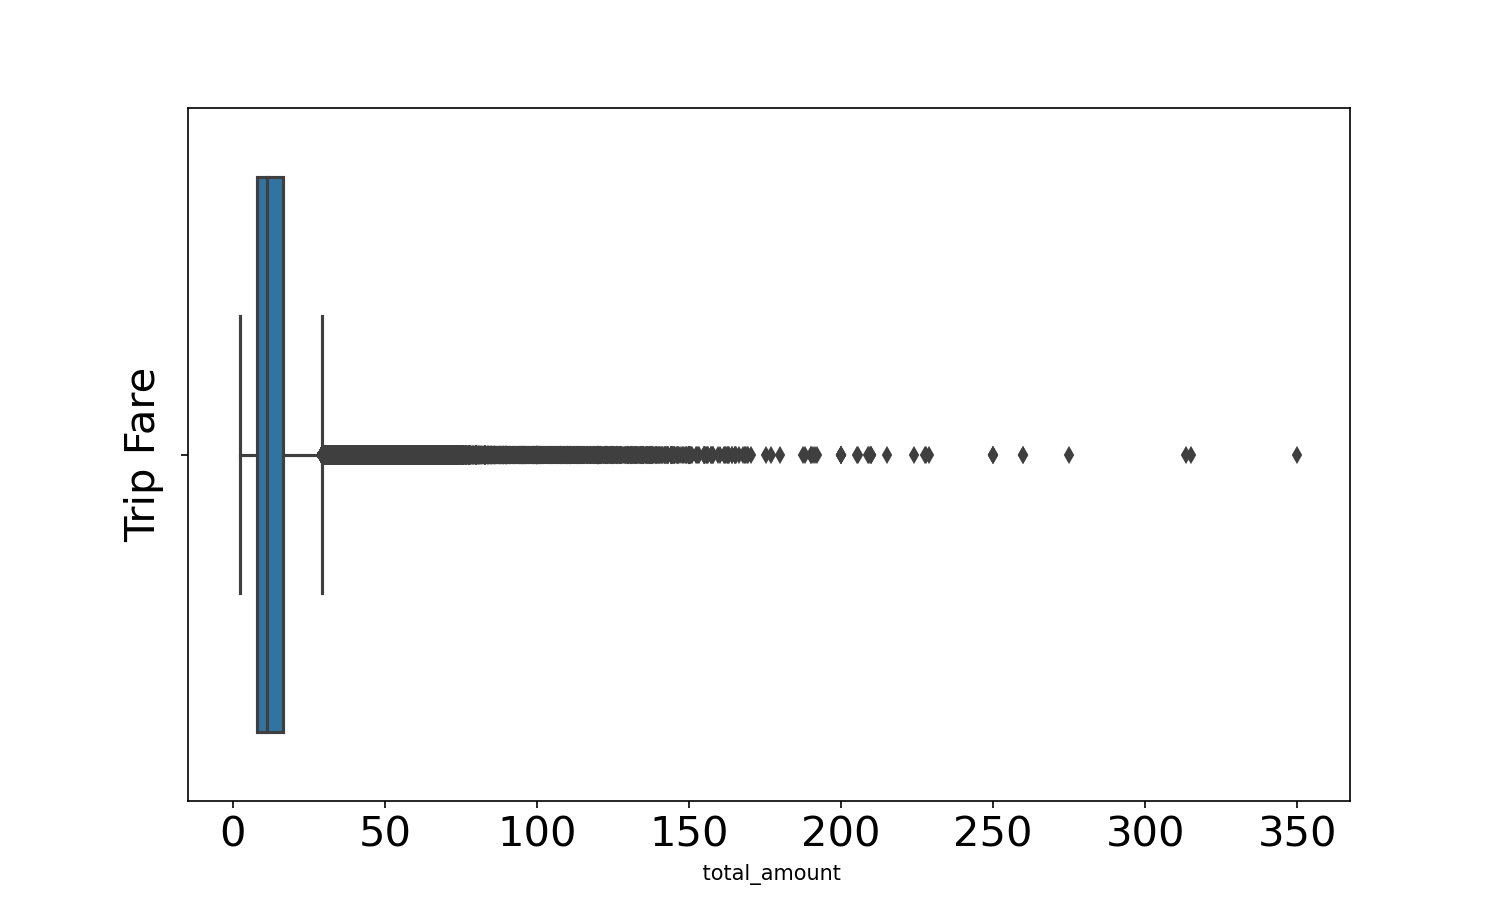

In [38]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(" total_amount", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Fare", fontsize = 20)
plt.show()

In [39]:
quantile_totalAmount = new_frame_cleaned[' total_amount'].quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [40]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of trip fare is {}".format(int(i*100), quantile_totalAmount[i]))

0th percentile value of trip fare is 2.5
10th percentile value of trip fare is 6.5
20th percentile value of trip fare is 7.5
30th percentile value of trip fare is 8.5
40th percentile value of trip fare is 10.0
50th percentile value of trip fare is 11.4
60th percentile value of trip fare is 13.0
70th percentile value of trip fare is 15.0
80th percentile value of trip fare is 18.5
90th percentile value of trip fare is 26.0
100th percentile value of trip fare is 350.0


In [41]:
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print("{} percentile value of trip fare is {}".format(int(i*100), quantile_totalAmount[i]))

91 percentile value of trip fare is 27.5
92 percentile value of trip fare is 29.37
93 percentile value of trip fare is 31.5
94 percentile value of trip fare is 34.5
95 percentile value of trip fare is 37.8
96 percentile value of trip fare is 41.4
97 percentile value of trip fare is 46.2
98 percentile value of trip fare is 54.0
99 percentile value of trip fare is 62.83
100 percentile value of trip fare is 350.0


In [42]:
quantile_totalAmount = new_frame_cleaned[' total_amount'].quantile(np.round(np.arange(0.991, 1.001, 0.001), 3))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} percentile value of trip fare is {}".format((i*100), quantile_totalAmount[i]))

99.1 percentile value of trip fare is 63.0
99.2 percentile value of trip fare is 64.59
99.3 percentile value of trip fare is 65.83
99.4 percentile value of trip fare is 67.83
99.5 percentile value of trip fare is 69.38
99.6 percentile value of trip fare is 69.39
99.7 percentile value of trip fare is 69.39
99.8 percentile value of trip fare is 70.0
99.9 percentile value of trip fare is 72.28
100.0 percentile value of trip fare is 350.0


In [43]:
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned[' total_amount']>0) & (new_frame_cleaned[' total_amount']<86.6)]

In [44]:
new_frame_cleaned.shape[0]

6954606

数据准备

Clustering/Segmentation

In [38]:
coord = new_frame_cleaned[[" pickup_latitude", " pickup_longitude"]].values
neighbors = []

#计算聚类中心之间的最小距离，并根据距离范围内的点和距离范围外的点的数量，提供有关聚类质量的一些统计信息
def min_distance(regionCenters, totalClusters):
    good_points = 0#特定范围内的好点
    bad_points = 0#特定范围内的坏点
    less_dist = []#距离范围内的点的数量
    more_dist = []#距离范围外的点的数量
    min_distance = 100000  #any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        #通过两个嵌套的循环迭代，计算了regionCenters中每个聚类中心与其他聚类中心之间的距离
        for j in range(totalClusters):
            if j != i:
                #每次迭代中，计算 regionCenters 中第 i 个和第 j 个位置的经纬度之间的距离
                #距离计算：使用 gpxpy.geo.haversine_distance 函数计算两个经纬度之间的距离。这个函数计算了两个点之间的哈弗斯因距离（Haversine distance），返回的距离单位是米
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
    
                #"gpxpy.geo.haversine_distance" gives distance between two latitudes and longitudes in meters. So, we have to convert it into miles.
                distance = distance/(1.60934*1000)   #distance from meters to miles
                min_distance = min(min_distance, distance) #最小距离更新：使用 min 函数更新 min_distance，将其设为当前计算得到的距离 distance 和 min_distance 中的较小值
                if distance < 2:
                    good_points += 1#好点坏点的判断
                else:
                    bad_points += 1
        #计数结果记录
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-"*10)

#接受一个参数noOfRegions,表示所需的聚类数,使用MiniBatchKMeans算法对经纬度数据进行聚类，
#得到聚类中心的坐标集合regionCenters。然后，函数返回聚类中心和总聚类数totalClusters
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

In [46]:
#不同cluster size情况下聚类中心之间的最小距离和聚类质量的统计信息

startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time taken = "+str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 8.0
Minimum distance between any two clusters = 0.9804840383538567
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 5.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 15.0
Minimum distance between any two clusters = 0.5820585520456732
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 8.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 22.0
Minimum distance between any two clusters = 0.4268104685851048
----------
On choosing a cluster size of 40
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 10.0
Avg. Number clusters outside of vicinity where int

比较合适的集群距离：30

In [47]:
#用MiniBatchKMeans函数进行聚类（比KMeans更快并且结果也比较准确）
coord = new_frame_cleaned[[" pickup_latitude", " pickup_longitude"]].values
regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(coord)
new_frame_cleaned["pickup_cluster"] = regions.predict(new_frame_cleaned[[" pickup_latitude", " pickup_longitude"]])

In [48]:
new_frame_cleaned.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,pickup_time,speed,pickup_cluster
0,1,2.5,-73.958848,40.763585,-73.986284,40.752034,22.2,29.300000,1.396922e+09,5.119454,24
2,2,0.6,-73.992233,40.729136,-73.991387,40.735186,7.2,5.216667,1.396922e+09,6.900958,5
3,2,0.5,-73.973726,40.750095,-73.976889,40.755623,10.2,11.183333,1.396919e+09,2.682563,29
4,1,0.4,-73.973502,40.755479,-73.979198,40.758619,7.2,6.016667,1.396921e+09,3.988920,29
5,1,0.8,-73.963002,40.766355,-73.953768,40.778865,7.8,6.316667,1.396918e+09,7.598945,2


In [49]:
centerOfRegions = regions.cluster_centers_
noOfClusters = len(centerOfRegions)
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

for i in range(noOfClusters):
    folium.Marker([centerOfRegions[i][0], centerOfRegions[i][1]], popup = (str(np.round(centerOfRegions[i][0], 2))+", "+str(np.round(centerOfRegions[i][1], 2)))).add_to(m)
m

<IPython.core.display.Javascript object>


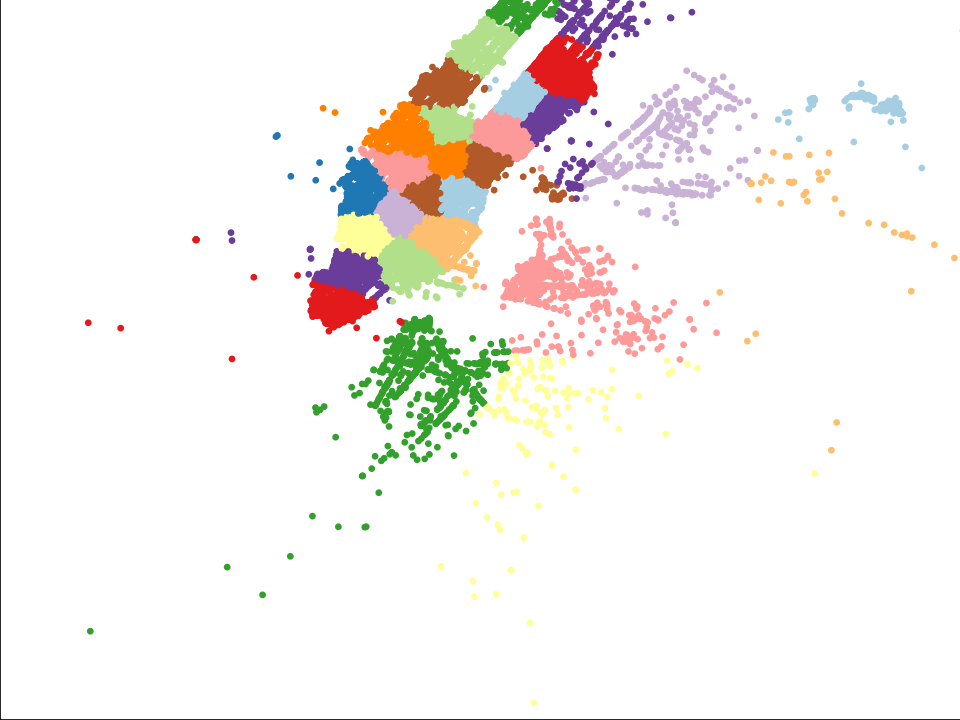

In [50]:
#聚类结果可视化
NYC_latitude_range = (40.5774, 40.9176)
NYC_Longitude_range = (-74.15, -73.7004)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = new_frame_cleaned[' pickup_longitude'].values[:70000], y = new_frame_cleaned[' pickup_latitude'].values[:70000], c = new_frame_cleaned.pickup_cluster.values[:70000], cmap = "Paired", s = 5)
ax.set_xlim(-74.10, -73.72)
ax.set_ylim(40.5774, 40.9176)
ax.set_title("Regions in New York City")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#Longitude values vary from left to right i.e., horizontally
#Latitude values vary from top to bottom means i.e., vertically

时间分箱

In [51]:
# 1396281600:2014-04-01 00:00:00   (Equivalent unix time)
# 1427817600 : 2015-04-01 00:00:00   (Equivalent unix time)

#将给定时间按照10分钟的时间间隔进行分组。
def pickup_10min_bins(dataframe, month, year):
    pickupTime = dataframe[" pickup_time"].values
    unixTime = [1396285200, 1427821200]
    unix_year = unixTime[year-2014]
    time_10min_bin = [int((i - unix_year)/600) for i in pickupTime]
    dataframe["time_bin"] = np.array(time_10min_bin)
    return dataframe

In [52]:
timestamp1 = "2015-04-01 00:00:00" 
dt1 = datetime.strptime(timestamp1, "%Y-%m-%d %H:%M:%S")
print(timeToUnix(timestamp1))

1427821200.0


In [53]:
april_2014_data = pickup_10min_bins(new_frame_cleaned, 4, 2014)

In [54]:
april_2014_data.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,pickup_time,speed,pickup_cluster,time_bin
0,1,2.5,-73.958848,40.763585,-73.986284,40.752034,22.2,29.300000,1.396922e+09,5.119454,24,1061
2,2,0.6,-73.992233,40.729136,-73.991387,40.735186,7.2,5.216667,1.396922e+09,6.900958,5,1060
3,2,0.5,-73.973726,40.750095,-73.976889,40.755623,10.2,11.183333,1.396919e+09,2.682563,29,1056
4,1,0.4,-73.973502,40.755479,-73.979198,40.758619,7.2,6.016667,1.396921e+09,3.988920,29,1059
5,1,0.8,-73.963002,40.766355,-73.953768,40.778865,7.8,6.316667,1.396918e+09,7.598945,2,1055


In [55]:
print("There should be ((24*60)/10)*30 unique 10 minute time bins for the month of April 2014: ", str(len(np.unique(april_2014_data["time_bin"]))))

There should be ((24*60)/10)*30 unique 10 minute time bins for the month of April 2014:  4320


In [56]:
april_2014_timeBin_groupBy = april_2014_data[["pickup_cluster", "time_bin", " trip_distance"]].groupby(by = ["pickup_cluster", "time_bin"]).count()

In [57]:
april_2014_timeBin_groupBy.head()

trip_distance
pickup_cluster time_bin                
0              0                     38
               1                     37
               2                     26
               3                      4
               4                      4

In [58]:
# Up till now we cleaned data and prepared data for the month of April 2014.

# now doing the same operations for the month of April 2015.

# 1. Get the dataframe which includes only required colums.
# 2. Add trip_duration, speed, unix time stamp of pickup_time.
# 4. Remove the outliers based on trip_duration, speed, trip_distance, total_amount.
# 5. Remove all the points where pickup and dropoff are outside of New York City area.
# 6. Add pickup_cluster to each data point.
# 7. Add time_bin (index of 10min intravel to which that trip belongs to).
# 8. Group by data, based on 'pickup_cluster' and 'time_bin'
startTime = datetime.now()
frame_2015 = dd.read_csv(r"C:\Users\lenovo\Desktop\yellow_tripdata_2015-04.csv",dtype={'extra': 'float64'})
print(len(frame_2015))


1048575


In [59]:
from datetime import datetime

# 定义输入字符串和目标格式
column_name = ' pickup_datetime'
input_format = "%Y/%m/%d %H:%M"  # 输入字符串的格式
output_format = "%Y-%m-%d %H:%M:%S"  # 目标格式，例如：May 01, 2023

# 将输入列转换为datetime格式
frame_2015[column_name] = dd.to_datetime(frame_2015[column_name], format=input_format)

# 将datetime格式的列转换为目标格式的字符串列
frame_2015[column_name] = frame_2015[column_name].dt.strftime(output_format)

# 执行转换操作
frame_2015 = frame_2015.compute()

#print(frame_2015.head())  # 输出转换后的Dask DataFrame的前几行


In [60]:
column_name1 = ' dropoff_datetime'
frame_2015[column_name1] = dd.to_datetime(frame_2015[column_name1], format=input_format)
frame_2015[column_name1] = frame_2015[column_name1].dt.strftime(output_format)
print(frame_2015.head())

   VendorID      pickup_datetime     dropoff_datetime   passenger_count  \
0         2  2015-04-27 15:16:00  2015-04-27 15:26:00                 1   
1         2  2015-04-27 15:16:00  2015-04-27 15:25:00                 1   
2         2  2015-04-27 15:16:00  2015-04-27 15:31:00                 1   
3         2  2015-04-27 15:16:00  2015-04-27 15:25:00                 1   
4         2  2015-04-27 15:16:00  2015-04-27 15:45:00                 1   

    trip_distance   pickup_longitude   pickup_latitude  RateCodeID  \
0            1.05         -73.988869         40.758396           1   
1            2.67         -74.008568         40.704479           1   
2            2.89         -73.994118         40.756432           1   
3            0.94         -73.974388         40.761665           1   
4            2.30         -73.972183         40.762726           1   

  store_and_fwd_flag   dropoff_longitude   dropoff_latitude  payment_type  \
0                  N          -73.984779          4

数据准备（2015年4月的数据）

In [61]:
frame_2015.columns

Index(['VendorID', ' pickup_datetime', ' dropoff_datetime', ' passenger_count',
       ' trip_distance', ' pickup_longitude', ' pickup_latitude', 'RateCodeID',
       'store_and_fwd_flag', ' dropoff_longitude', ' dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', ' total_amount'],
      dtype='object')

In [62]:
frame_2015 = dd.from_pandas(frame_2015, npartitions=2)

In [63]:
print("Preparation OF April 2015 data.")
print("-"*35)

print("Number of columns = "+str(len(frame_2015.columns)))
print("-"*35)

new_frame2 = dfWithTripTimes(frame_2015)
print("New Frame for April 2015 creation done")
print("-"*35)

new_frame_cleaned2 = new_frame2[(new_frame2[' trip_duration']>1) & (new_frame2[' trip_duration']<720)]
print("Trip Duration Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(new_frame_cleaned2['speed']>0) & (new_frame_cleaned2['speed']<45.31)]
print("Speed Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(new_frame_cleaned2[' trip_distance']>0) & (new_frame_cleaned2[' trip_distance']<23)]
print("Trip Distance Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(new_frame_cleaned2[' total_amount']>0) & (new_frame_cleaned2[' total_amount']<86.6)]
print("Total Amount Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(((new_frame_cleaned2[' pickup_latitude'] >= 40.5774) & (new_frame_cleaned2[' pickup_latitude'] <= 40.9176)) & ((new_frame_cleaned2[' pickup_longitude'] >= -74.15) & (new_frame_cleaned2[' pickup_longitude'] <= -73.7004)))]
print("Pickups outside of NYC are removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(((new_frame_cleaned2[' dropoff_latitude'] >= 40.5774) & (new_frame_cleaned2[' dropoff_latitude'] <= 40.9176)) & ((new_frame_cleaned2[' dropoff_longitude'] >= -74.15) & (new_frame_cleaned2[' dropoff_longitude'] <= -73.7004)))]
print("Dropoffs outside of NYC are removed")
print("-"*35)

new_frame_cleaned2["pickup_cluster"] = regions.predict(new_frame_cleaned2[[" pickup_latitude", " pickup_longitude"]])
print("Pickup Clusters are assigned")
print("-"*35)

april_2015_data = pickup_10min_bins(new_frame_cleaned2, 4, 2015)
print("Pickup time bins are assigned")
print("-"*35)

april_2015_timeBin_groupBy = april_2015_data[["pickup_cluster", "time_bin", " trip_distance"]].groupby(by = ["pickup_cluster", "time_bin"]).count()
print("Pickup cluster and time bins are grouped.")
print("-"*35)

print("Done...")
print("-"*35)

print("Fraction of Total data left = "+str(new_frame_cleaned2.shape[0]/new_frame2.shape[0]))
print("Total Number of outliers removed = "+str(new_frame2.shape[0] - new_frame_cleaned2.shape[0]))
print("-"*35)

print("Total Time taken for execution of April 2015 data = "+str(datetime.now() - startTime))
print("-"*35)

Preparation OF April 2015 data.
-----------------------------------
Number of columns = 19
-----------------------------------
Time taken for creation of dataframe is 0:00:48.938018
New Frame for April 2015 creation done
-----------------------------------
Trip Duration Outliers removed
-----------------------------------
Speed Outliers removed
-----------------------------------
Trip Distance Outliers removed
-----------------------------------
Total Amount Outliers removed
-----------------------------------
Pickups outside of NYC are removed
-----------------------------------
Dropoffs outside of NYC are removed
-----------------------------------
Pickup Clusters are assigned
-----------------------------------
Pickup time bins are assigned
-----------------------------------
Pickup cluster and time bins are grouped.
-----------------------------------
Done...
-----------------------------------
Fraction of Total data left = 0.9648637436520993
Total Number of outliers removed = 3684

In [64]:
april_2015_data.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,pickup_time,speed,pickup_cluster,time_bin
0,1,1.05,-73.988869,40.758396,-73.984779,40.748272,8.30,10.0,1.430123e+09,6.300000,18,3835
1,1,2.67,-74.008568,40.704479,-73.978271,40.720543,12.30,9.0,1.430123e+09,17.800000,14,3835
2,1,2.89,-73.994118,40.756432,-73.993263,40.724442,16.62,15.0,1.430123e+09,11.560000,18,3835
3,1,0.94,-73.974388,40.761665,-73.985542,40.756168,8.30,9.0,1.430123e+09,6.266667,10,3835
4,1,2.30,-73.972183,40.762726,-73.990845,40.750671,18.30,29.0,1.430123e+09,4.758621,10,3835


In [65]:
april_2015_timeBin_groupBy.head()

trip_distance
pickup_cluster time_bin                
0              1                      1
               2                      2
               3                      5
               5                      1
               11                     1

平滑

In [66]:
# Gets the unique time bins where pickup values are present for each region.

# for each cluster region we will collect all the indices of 10min intervals in which pickups happened.
# we got an observation that there are some time bins that doesn't have any pickups.

#找出有多少个时间间隔（time_bin）在任何一个聚类簇区域中没有乘车数据。
def getUniqueBinsWithPickups(dataframe):
    values = []
    for i in range(30):          #we have total 30 clusters
        cluster_id = dataframe[dataframe["pickup_cluster"] == i]
        unique_clus_id = list(set(cluster_id["time_bin"]))
        unique_clus_id.sort()   #inplace sorting
        values.append(unique_clus_id)
    return values
#this function is returning the indices of all the unique time_bins where there is a pickup for all the 30 clusters.

In [67]:
#now for April-2014, we have to find out, how many time_bins are there where there is no pickup in any of the cluster region
unique_binswithPickup_April_2014 = getUniqueBinsWithPickups(april_2014_data)
for i in range(30):             #we have total 30 clusters
    print("For cluster ID {}, total number of time bins with no pickup in this clutser region is {}".format(i, (4464 - len(unique_binswithPickup_April_2014[i]))))
    print("-"*90)
#there are total 4464 time bins in April - 2014.
#"unique_binswithPickup_April_2014" contains all the unique time bins, where pickup happened. It contains 30 sub-arrays as there are 30 clusters
#and each sub-array contains the unique ID of all the time bins where pickup happened in the clusters which is the index of that sub-array.

For cluster ID 0, total number of time bins with no pickup in this clutser region is 424
------------------------------------------------------------------------------------------
For cluster ID 1, total number of time bins with no pickup in this clutser region is 146
------------------------------------------------------------------------------------------
For cluster ID 2, total number of time bins with no pickup in this clutser region is 199
------------------------------------------------------------------------------------------
For cluster ID 3, total number of time bins with no pickup in this clutser region is 285
------------------------------------------------------------------------------------------
For cluster ID 4, total number of time bins with no pickup in this clutser region is 144
------------------------------------------------------------------------------------------
For cluster ID 5, total number of time bins with no pickup in this clutser region is 144
-----------

In [80]:
# 将缺失的值填充为0
def fillMissingWithZero(numberOfPickups, correspondingTimeBin):
    ind = 0
    smoothed_regions = []
    for c in range(0, 30):
        smoothed_bins = []
        for t in range(4464):    #there are total 4464 time bins in both April-2014 & Jau-2015.
            if t in correspondingTimeBin[c]:   #if a time bin is present in "correspondingTimeBin" in cluster 'c', 
            #then it means there is a pickup, in this case, we are simply adding number of pickups, else we are adding 0.
                smoothed_bins.append(numberOfPickups[ind])
                ind += 1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions
#above function performs the operation in this way: if in any cluster if there is no pickup in any of the 4464 time bins, then 
#it simply appends 0 in that missing time_bin else it adds the original number of pickups in that time_bins.

In [81]:
def smoothing(numberOfPickups, correspondingTimeBin):
    ind = 0
    repeat = 0
    smoothed_region = []
    for cluster in range(0, 30):
        smoothed_bin = []
        for t1 in range(4464):
            if repeat != 0:   #this will ensure that we shall not fill the pickup values again which we already filled by smoothing
                repeat -= 1
            else:
                if t1 in correspondingTimeBin[cluster]:
                    smoothed_bin.append(numberOfPickups[ind])
                    ind += 1
                else:
                    if t1 == 0:           
    #<---------------------CASE-1:Pickups missing in the beginning------------------------>
                        for t2 in range(t1, 4464):
                            if t2 not in correspondingTimeBin[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                smoothed_value = (numberOfPickups[ind]*1.0)/((right_hand_limit + 1)*1.0)
                                for i in range(right_hand_limit + 1):
                                    smoothed_bin.append(math.ceil(smoothed_value))
                                ind += 1
                                repeat = right_hand_limit - t1
                                
                    if t1 != 0:
                        right_hand_limit = 0
                        for t2 in range(t1, 4464):
                            if t2 not in correspondingTimeBin[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                break
                        if right_hand_limit == 0:
    #<---------------------CASE-2: Pickups MISSING IN THE END------------------------------>
                            smoothed_value = (numberOfPickups[ind-1]*1.0)/(((4464 - t1)+1)*1.0)
                            del smoothed_bin[-1]
                            for i in range((4464 - t1)+1):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            repeat = (4464 - t1) - 1    
    #<---------------------CASE-3: Pickups MISSING IN MIDDLE OF TWO VALUES----------------> 
                        else: 
                            smoothed_value = ((numberOfPickups[ind-1] + numberOfPickups[ind])*1.0)/(((right_hand_limit - t1)+2)*1.0)
                            del smoothed_bin[-1]
                            for i in range((right_hand_limit - t1)+2):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            ind += 1
                            repeat = right_hand_limit - t1                        
        smoothed_region.extend(smoothed_bin)
    return smoothed_region

# 函数处理了三种情况：
#情况1：乘车数量在时间序列的开头缺失。在这种情况下，函数会计算缺失部分的平均乘车数量，并将其添加到平滑后的列表中。
#情况2：乘车数量在时间序列的末尾缺失。在这种情况下，函数会计算缺失部分的平均乘车数量，并将其添加到平滑后的列表中。
#情况3：乘车数量在时间序列的中间缺失。在这种情况下，函数会计算缺失部分两侧乘车数量的平均值，并将平均值添加到平滑后的列表中。

In [82]:
april_2014_fillZero = fillMissingWithZero(april_2014_timeBin_groupBy[" trip_distance"].values, unique_binswithPickup_April_2014)

In [83]:
april_2014_fillSmooth = smoothing(april_2014_timeBin_groupBy[" trip_distance"].values, unique_binswithPickup_April_2014)

In [72]:
def countZeros(num):
    count = 0
    for i in num:
        if i == 0:
            count += 1
    return count

In [73]:
print("Number of values filled with zero in zero fill data= "+str(countZeros(april_2014_fillZero)))
print("Sanity check for number of zeros in smoothed data = "+str(countZeros(april_2014_fillSmooth)))

Number of values filled with zero in zero fill data= 6088
Sanity check for number of zeros in smoothed data = 0


In [74]:
print("Total number of pickup values = "+str(len(april_2014_fillZero)))
print("Total number of pickup values = "+str(len(april_2014_fillSmooth)))

Total number of pickup values = 133920
Total number of pickup values = 133920


In [75]:
unique_binswithPickup_April_2015 = getUniqueBinsWithPickups(april_2015_data)

In [76]:
# April-2014 data is smoothed, April-2015 data missing values are filled with zero
april_2015_fillZero = fillMissingWithZero(april_2015_timeBin_groupBy[" trip_distance"].values, unique_binswithPickup_April_2015)

In [77]:
#按聚类区域分组的乘车次数值列表

regionWisePickup_April_2015 = []
for i in range(30):
    regionWisePickup_April_2015.append(april_2015_fillZero[4464*i:((4464*i)+4464)])
#"regionWisePickup_April_2015" is a list of lists which contains 30 sub lists, where the index of each sub-list is the 
#corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4464 time bins 
#in April 2015, hence, each sub-list is of size 4464.

In [78]:
print(len(regionWisePickup_April_2015))
print(len(regionWisePickup_April_2015[0]))

30
4464


基准模型

In [84]:
Ratios_DF = pd.DataFrame()
Ratios_DF["Given"] = april_2014_fillSmooth
Ratios_DF["Prediction"] = april_2015_fillZero
Ratios_DF["Ratio"] = Ratios_DF["Prediction"]*1.0/Ratios_DF["Given"]*1.0

In [85]:
Ratios_DF.head()

,Given,Prediction,Ratio
0,38,0,0.000000
1,37,1,0.027027
2,26,2,0.076923
3,4,5,1.250000
4,4,0,0.000000


In [86]:
print("Total Number of zeros in Ratio column = "+str(Ratios_DF["Ratio"].value_counts()[0]))

Total Number of zeros in Ratio column = 51372


In [87]:
print("Total Number of zeros in Prediction column = "+str(Ratios_DF["Prediction"].value_counts()[0]))

Total Number of zeros in Prediction column = 51372


简单移动平均

In [88]:
def simple_moving_average_ratios(ratios):
    predicted_ratio = (ratios["Ratio"].values)[0]
    predicted_ratio_values = []
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 3
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_ratio_values.append(predicted_ratio)
            predicted_pickup_values.append(int(predicted_ratio_values[i] * ratios["Given"].values[i]))
            absolute_error.append(abs(int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]))
            
            error = math.pow((int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            predicted_ratio = sum(ratios["Ratio"].values[(i+1) - window_size:(i+1)])
            predicted_ratio = predicted_ratio/window_size
        else:
            predicted_ratio = sum(ratios["Ratio"].values[0:(i+1)])
            predicted_ratio = predicted_ratio/(i+1)
            
    ratios["Simple_Moving_Average_Ratios_Pred"] = predicted_pickup_values
    ratios["Simple_Moving_Average_Ratios_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

In [89]:
def simple_moving_average_predictions(ratios):
    predicted_pickup = (ratios["Prediction"].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 2
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_pickup_values.append(predicted_pickup)
            absolute_error.append(abs(predicted_pickup_values[i] - ratios["Prediction"].values[i]))
            
            error = math.pow((predicted_pickup_values[i] - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            predicted_pickup = sum(ratios["Prediction"].values[(i+1) - window_size:(i+1)])
            predicted_pickup = predicted_pickup/window_size
        else:
            predicted_pickup = sum(ratios["Prediction"].values[0:(i+1)])
            predicted_pickup = predicted_pickup/(i+1)
            
    ratios["Simple_Moving_Average_Predictions_Pred"] = predicted_pickup_values
    ratios["Simple_Moving_Average_Predictions_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

简单加权移动平均

In [90]:
def weighted_moving_average_ratios(ratios):
    predicted_ratio = (ratios["Ratio"].values)[0]
    predicted_ratio_values = []
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 4
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_ratio_values.append(predicted_ratio)
            predicted_pickup_values.append(int(predicted_ratio_values[i] * ratios["Given"].values[i]))
            absolute_error.append(abs(int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]))
            
            error = math.pow((int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            sumOfRatios = 0
            sumOfWeights = 0
            for j in range(window_size, 0, -1):
                sumOfRatios = sumOfRatios + j*(ratios["Ratio"].values)[i -window_size + j]
                sumOfWeights = sumOfWeights + j
            predicted_ratio = sumOfRatios/sumOfWeights
        else:
            sumOfRatios = 0
            sumOfWeights = 0
            for j in range(i+1, 0, -1):
                sumOfRatios = sumOfRatios + j*(ratios["Ratio"].values)[j-1]
                sumOfWeights = sumOfWeights + j
            predicted_ratio = sumOfRatios/sumOfWeights
    
    ratios["Weighted_Moving_Average_Ratios_Pred"] = predicted_pickup_values
    ratios["Weighted_Moving_Average_Ratios_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

In [91]:
def weighted_moving_average_predictions(ratios):
    predicted_pickup = (ratios["Prediction"].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 2
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_pickup_values.append(predicted_pickup)
            absolute_error.append(abs(predicted_pickup_values[i] - ratios["Prediction"].values[i]))
            
            error = math.pow(int(predicted_pickup_values[i] - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            sumPickups = 0
            sumOfWeights = 0
            for j in range(window_size, 0, -1):
                sumPickups = sumPickups + j*(ratios["Prediction"].values)[i -window_size + j]
                sumOfWeights = sumOfWeights + j
            predicted_pickup = sumPickups/sumOfWeights
        else:
            sumPickups = 0
            sumOfWeights = 0
            for j in range(i+1, 0, -1):
                sumPickups += j*(ratios["Prediction"].values)[j-1]
                sumOfWeights += j
            predicted_pickup = sumPickups/sumOfWeights
    
    ratios["Weighted_Moving_Average_Predictions_Pred"] = predicted_pickup_values
    ratios["Weighted_Moving_Average_Predictions_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

指数加权移动平均

In [92]:
def exponential_weighted_moving_average_ratios(ratios):
    predicted_ratio = (ratios["Ratio"].values)[0]
    predicted_ratio_values = []
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    alpha = 0.5
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_ratio_values.append(predicted_ratio)
            predicted_pickup_values.append(int(predicted_ratio_values[i] * ratios["Given"].values[i]))
            absolute_error.append(abs(int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]))
            error = math.pow((int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            predicted_ratio = alpha*predicted_ratio + ((1-alpha)*ratios["Ratio"].values[i-1])
            
            
    ratios["Exponential_Weighted_Moving_Average_Ratios_Pred"] = predicted_pickup_values
    ratios["Exponential_Weighted_Moving_Average_Ratios_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

In [93]:
def exponential_weighted_moving_average_predictions(ratios):
    predicted_pickup = (ratios["Prediction"].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    alpha = 0.5
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_pickup_values.append(predicted_pickup)
            absolute_error.append(abs(predicted_pickup_values[i] - ratios["Prediction"].values[i]))
            error = math.pow((predicted_pickup_values[i] - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            predicted_pickup = alpha*predicted_pickup + ((1-alpha)*ratios["Prediction"].values[i-1])
            
            
    ratios["Exponential_Weighted_Moving_Average_Predictions_Pred"] = predicted_pickup_values
    ratios["Exponential_Weighted_Moving_Average_Predictions_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

In [94]:
r1, mape1, mse1 = simple_moving_average_ratios(Ratios_DF)
r2, mape2, mse2 = simple_moving_average_predictions(Ratios_DF)
r3, mape3, mse3 = weighted_moving_average_ratios(Ratios_DF)
r4, mape4, mse4 = weighted_moving_average_predictions(Ratios_DF)
r5, mape5, mse5 = exponential_weighted_moving_average_ratios(Ratios_DF)
r6, mape6, mse6 = exponential_weighted_moving_average_predictions(Ratios_DF)

In [95]:
error_table_baseline = pd.DataFrame(columns = ["Model", "MAPE(%)", "MSE"])

error_table_baseline = error_table_baseline.append(pd.DataFrame([["Simple Moving Average Ratios", mape1*100, mse1]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Simple Moving Average Predictions", mape2*100, mse2]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Weighted Moving Average Ratios", mape3*100, mse3]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Weighted Moving Average Predictions", mape4*100, mse4]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Exponential Weighted Moving Average Ratios", mape5*100, mse5]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Exponential Weighted Moving Average Predictions", mape6*100, mse6]], columns = ["Model", "MAPE(%)", "MSE"]))

error_table_baseline.reset_index(drop = True, inplace = True)

In [96]:
error_table_baseline.style.highlight_min(axis=0)

,Model,MAPE(%),MSE
0,Simple Moving Average Ratios,83.795017,100.992720
1,Simple Moving Average Predictions,87.691899,110.357624
2,Weighted Moving Average Ratios,84.602148,102.130877
3,Weighted Moving Average Predictions,92.072769,117.740278
4,Exponential Weighted Moving Average Ratios,79.507221,91.720789
5,Exponential Weighted Moving Average Predictions,78.651031,87.892834


回归模型

In [97]:
#"regionWisePickup_April_2015" is a list of lists which contains 30 sub lists, where the index of each sub-list is the 
#corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4464 time bins 
#in April 2015, hence, each sub-list is of size 4464.
#"regionWisePickup_April_2015" is a list of lists [[x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], .. 30 lists]
#Here, x1,x2,x3... are pickup values at time stamp 1,2,3... respectively


#定义了一个变量number_of_time_stamps，表示在训练数据中考虑过去的5个10分钟时间段的总共的pickup数量
number_of_time_stamps = 5

# TruePickups varaible
# it is list of lists
#定义了一个空的TruePickups列表，用于存储每个簇(cluster)的真实标签/地面真实pickup数量
#由于在训练时使用过去的5个pickup作为预测的依据，所以TruePickups不包含每个簇的前5个pickup。每个簇的TruePickups列表长度为4459
TruePickups = []

# Ex: [[cent_lat 4459 times],[cent_lat 4459 times], [cent_lat 4459 times].... 30 lists]
# it is list of lists
#定义了一个lat列表，用于存储每个簇的中心点的纬度信息

lat = []

# Ex: [[cent_lat 4459 times],[cent_lat 4459 times], [cent_lat 4459 times].... 30 lists]
# it is list of lists
#定义了一个lon列表，用于存储每个簇的中心点的经度信息
lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
#定义了一个day_of_week列表，用于存储每个pickup时间段所属的星期几信息
day_of_week = []


# for every cluster we will be adding 4459 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists

# feat is a numbpy array, of shape (133770, 5). {4459*30 = 133770.}
# each row corresponds to an entry in our data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1st 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
feat = []


centerOfRegions = regions.cluster_centers_
feat = [0]*number_of_time_stamps
for i in range(30):
    lat.append([centerOfRegions[i][0]]*4459) 
    lon.append([centerOfRegions[i][1]]*4459)
    #1 April 2015 is a Friday so we start our day from 5: "(int(j/144))%7+5"
    # Our prediction starts from 5th 10min interval since we need to have number of pickups that are happened in last 5 pickup bins.
    day_of_week.append([int(((int(j/144)%7)+5)%7) for j in range(5, 4464)])
    #"regionWisePickup_April_2015" is a list of lists which contains 30 sub lists, where the index of each sub-list is the 
    #corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4464 time bins 
    #in April 2015, hence, each sub-list is of size 4464.
    #"regionWisePickup_April_2015" is a list of lists [[x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], .. 30 lists]
    #Here, x1,x2,x3... are pickup values at time stamp 1,2,3... respectively
    feat = np.vstack((feat, [regionWisePickup_April_2015[i][k:k+number_of_time_stamps] for k in range(0, len(regionWisePickup_April_2015[i]) - (number_of_time_stamps))]))
    TruePickups.append(regionWisePickup_April_2015[i][5:])
    #output contains pickup values of all the regions and of each time stamp, except first 5 time stamp pickups of each region.
feat = feat[1:]

In [98]:
len(lat[0])*len(lat) == len(lon[0])*len(lon) == len(day_of_week[0])*len(day_of_week) == 4459*30 == len(feat) == len(TruePickups[0])*len(TruePickups)

True

In [99]:
feat

array([[0, 1, 2, 5, 0],
       [1, 2, 5, 0, 1],
       [2, 5, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int64)

将加权移动平均预测的结果作为特征添加到我们的数据中

In [100]:
# "predicted_pickup_values": it is a temporary array that store weighted moving avarag prediction values for each 10min intervl, 
# for each cluster it will get reset.
# for every cluster it contains 4464 values
predicted_pickup_values = []

# "predicted_pickup_values_list"
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x4463], [x5,x6,x7..x4463], [x5,x6,x7..x4463], ... 40 lists]
predicted_pickup_values_list = []

predicted_value = -1  #it will contain cuurent predicted_value. Default is given -1 which will be replaced later

window_size = 2
for i in range(30):
    for j in range(4464):
        if j == 0:
            predicted_value = regionWisePickup_April_2015[i][j]
            predicted_pickup_values.append(0)
        else:
            if j>=window_size:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(window_size, 0, -1):
                    sumPickups += k*(regionWisePickup_April_2015[i][j -window_size + (k - 1)])
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
            else:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(j, 0, -1):
                    sumPickups += k*regionWisePickup_April_2015[i][k-1]
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
                
    predicted_pickup_values_list.append(predicted_pickup_values[5:])
    predicted_pickup_values = []

In [101]:
len(predicted_pickup_values_list[0])*len(predicted_pickup_values_list) == 4459*30

True

将傅里叶变换的前5个频率和振幅作为特征添加到数据中。

In [ ]:
%matplotlib notebook
for i in range(30):
    fig = plt.figure(figsize = (8, 6))
    plt.plot(regionWisePickup_April_2015[i][:4464])
    plt.title("Pickup Pattern for Cluster Region "+str(i+1)+", for April-2015.")
    plt.xlabel("10 Minute Time Bins")
    plt.ylabel("Number of Pickups")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for i in range(30):
    Y  = np.abs(np.fft.fft(regionWisePickup_April_2015[i][0:4096]))
    # read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
    freq = np.abs(np.fft.fftfreq(4096, 1))
    n = len(freq)
    plt.figure(figsize = (8, 6))
    plt.plot(freq[:], Y[:])
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.title("Fourier Transformed Frequency and Amplitudes of Cluster Region "+str(i+1)+", for April 2015.")
    plt.show()
#Here, we are concern only about positive frequencies and ampllitudes. "np.fft.fftfreq(n, 1)" returns the frequency of sine 
#in a symmetric form, means there will be equal number of positive and negative sine wave frequencies. But we are concern only
#about positive ones.

In [104]:
#amplitude_lists和frequency_lists将包含所有聚类区域的频域特征，其中每个子列表对应于一个聚类区域，包含重复的振幅和频率值
amplitude_lists = []
frequency_lists = []
for i in range(30):
    ampli  = np.abs(np.fft.fft(regionWisePickup_April_2015[i][0:4096]))
    freq = np.abs(np.fft.fftfreq(4096, 1))
    ampli_indices = np.argsort(-ampli)[1:]        #it will return an array of indices for which corresponding amplitude values are sorted in reverse order.
    amplitude_values = []
    frequency_values = []
    for j in range(0, 9, 2):   #taking top five amplitudes and frequencies
        amplitude_values.append(ampli[ampli_indices[j]])
        frequency_values.append(freq[ampli_indices[j]])
    for k in range(4459):    #those top 5 frequencies and amplitudes are same for all the points in one cluster
        amplitude_lists.append(amplitude_values)
        frequency_lists.append(frequency_values) 

回归模型数据准备

In [105]:
print("size of total train data :" +str(int(133770*0.8)))
print("size of total test data :" +str(int(133770*0.2)))

size of total train data :107016
size of total test data :26754


In [106]:
print("size of train data for one cluster:" +str(int(4459*0.8)))
print("size of total test data for one cluster:" +str(int(4459*0.2)))

size of train data for one cluster:3567
size of total test data for one cluster:891


In [107]:
train_previousFive_pickups  = [feat[i*4459:(4459*i+3567)] for i in range(30)]
test_previousFive_pickups  = [feat[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [108]:
train_fourier_frequencies = [frequency_lists[i*4459:(4459*i+3567)] for i in range(30)]
test_fourier_frequencies = [frequency_lists[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [109]:
train_fourier_amplitudes = [amplitude_lists[i*4459:(4459*i+3567)] for i in range(30)]
test_fourier_amplitudes = [amplitude_lists[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [110]:
print("Train Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of training points = {}".format(len(train_previousFive_pickups), len(train_previousFive_pickups[0]), len(train_previousFive_pickups)*len(train_previousFive_pickups[0])))
print("Test Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of test points = {}".format(len(test_previousFive_pickups), len(test_previousFive_pickups[0]), len(test_previousFive_pickups)*len(test_previousFive_pickups[0])))

Train Data: Total number of clusters = 30. Number of points in each cluster = 3567. Total number of training points = 107010
Test Data: Total number of clusters = 30. Number of points in each cluster = 892. Total number of test points = 26760


In [111]:
#taking 80% data as train data from each cluster
train_lat = [i[:3567] for i in lat]
train_lon = [i[:3567] for i in lon]
train_weekDay = [i[:3567] for i in day_of_week]
train_weighted_avg = [i[:3567] for i in predicted_pickup_values_list]
train_TruePickups = [i[:3567] for i in TruePickups]

In [112]:
#taking 20% data as test data from each cluster
test_lat = [i[3567:] for i in lat]
test_lon = [i[3567:] for i in lon]
test_weekDay = [i[3567:] for i in day_of_week]
test_weighted_avg = [i[3567:] for i in predicted_pickup_values_list]
test_TruePickups = [i[3567:] for i in TruePickups]

In [113]:
# convert from lists of lists of list to lists of list
train_pickups = []
test_pickups = []
train_freq = []
test_freq = []
train_amp = []
test_amp = []
for i in range(30):
    train_pickups.extend(train_previousFive_pickups[i])
    test_pickups.extend(test_previousFive_pickups[i])
    train_freq.extend(train_fourier_frequencies[i])
    test_freq.extend(test_fourier_frequencies[i])
    train_amp.extend(train_fourier_amplitudes[i])
    test_amp.extend(test_fourier_amplitudes[i])

In [114]:
train_prevPickups_freq_amp = np.hstack((train_pickups, train_freq, train_amp))
test_prevPickups_freq_amp = np.hstack((test_pickups, test_freq, test_amp))

In [115]:
print("Number of data points in train data = {}. Number of columns till now = {}".format(len(train_prevPickups_freq_amp), len(train_prevPickups_freq_amp[0])))
print("Number of data points in test data = {}. Number of columns till now = {}".format(len(test_prevPickups_freq_amp), len(test_prevPickups_freq_amp[0])))

Number of data points in train data = 107010. Number of columns till now = 15
Number of data points in test data = 26760. Number of columns till now = 15


In [116]:
train_flat_lat = sum(train_lat, [])
train_flat_lon = sum(train_lon, [])
train_flat_weekDay = sum(train_weekDay, [])
train_weighted_avg_flat = sum(train_weighted_avg, [])
train_TruePickups_flat = sum(train_TruePickups, [])

test_flat_lat = sum(test_lat, [])
test_flat_lon = sum(test_lon, [])
test_flat_weekDay = sum(test_weekDay, [])
test_weighted_avg_flat = sum(test_weighted_avg, [])
test_TruePickups_flat = sum(test_TruePickups, [])

In [117]:
#train dataframe
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1', 'freq1', 'freq2','freq3','freq4','freq5', 'Amp1', 'Amp2', 'Amp3', 'Amp4', 'Amp5']
Train_DF = pd.DataFrame(data = train_prevPickups_freq_amp, columns = columns)
Train_DF["Latitude"] = train_flat_lat
Train_DF["Longitude"] = train_flat_lon
Train_DF["WeekDay"] = train_flat_weekDay
Train_DF["WeightedAvg"] = train_weighted_avg_flat

In [118]:
#test dataframe
Test_DF = pd.DataFrame(data = test_prevPickups_freq_amp, columns = columns)
Test_DF["Latitude"] = test_flat_lat
Test_DF["Longitude"] = test_flat_lon
Test_DF["WeekDay"] = test_flat_weekDay
Test_DF["WeightedAvg"] = test_weighted_avg_flat

In [119]:
print("Shape of train data = "+str(Train_DF.shape))
print("Shape of test data = "+str(Test_DF.shape))

Shape of train data = (107010, 19)
Shape of test data = (26760, 19)


In [120]:
Train_DF.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,freq1,freq2,freq3,freq4,freq5,Amp1,Amp2,Amp3,Amp4,Amp5,Latitude,Longitude,WeekDay,WeightedAvg
0,0.0,1.0,2.0,5.0,0.0,0.006836,0.00708,0.013916,0.001953,0.000977,5671.315203,5100.446055,4324.665884,3038.477566,2218.469095,40.771946,-73.869067,5,1
1,1.0,2.0,5.0,0.0,1.0,0.006836,0.00708,0.013916,0.001953,0.000977,5671.315203,5100.446055,4324.665884,3038.477566,2218.469095,40.771946,-73.869067,5,0
2,2.0,5.0,0.0,1.0,0.0,0.006836,0.00708,0.013916,0.001953,0.000977,5671.315203,5100.446055,4324.665884,3038.477566,2218.469095,40.771946,-73.869067,5,0
3,5.0,0.0,1.0,0.0,0.0,0.006836,0.00708,0.013916,0.001953,0.000977,5671.315203,5100.446055,4324.665884,3038.477566,2218.469095,40.771946,-73.869067,5,0
4,0.0,1.0,0.0,0.0,0.0,0.006836,0.00708,0.013916,0.001953,0.000977,5671.315203,5100.446055,4324.665884,3038.477566,2218.469095,40.771946,-73.869067,5,0


In [121]:
Test_DF.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,freq1,freq2,freq3,freq4,freq5,Amp1,Amp2,Amp3,Amp4,Amp5,Latitude,Longitude,WeekDay,WeightedAvg
0,2.0,5.0,6.0,0.0,5.0,0.006836,0.00708,0.013916,0.001953,0.000977,5671.315203,5100.446055,4324.665884,3038.477566,2218.469095,40.771946,-73.869067,1,3
1,5.0,6.0,0.0,5.0,0.0,0.006836,0.00708,0.013916,0.001953,0.000977,5671.315203,5100.446055,4324.665884,3038.477566,2218.469095,40.771946,-73.869067,1,1
2,6.0,0.0,5.0,0.0,0.0,0.006836,0.00708,0.013916,0.001953,0.000977,5671.315203,5100.446055,4324.665884,3038.477566,2218.469095,40.771946,-73.869067,1,0
3,0.0,5.0,0.0,0.0,1.0,0.006836,0.00708,0.013916,0.001953,0.000977,5671.315203,5100.446055,4324.665884,3038.477566,2218.469095,40.771946,-73.869067,1,0
4,5.0,0.0,0.0,1.0,0.0,0.006836,0.00708,0.013916,0.001953,0.000977,5671.315203,5100.446055,4324.665884,3038.477566,2218.469095,40.771946,-73.869067,1,0
